# Using Pandas read_json function:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
with open('yelp_dataset/yelp_academic_dataset_review.json') as file:
        review = pd.read_json(file, lines = True)

with open('yelp_dataset/yelp_academic_dataset_business.json') as file:
        business = pd.read_json(file, lines = True)

with open('yelp_dataset/yelp_academic_dataset_user.json') as file:
        user = pd.read_json(file, lines = True)

In [3]:
# with open('yelp_dataset/yelp_academic_dataset_tip.json') as file:
#         tip = pd.read_json(file, lines = True)

# with open('yelp_dataset/yelp_academic_dataset_checkin.json') as file:
#         checkin = pd.read_json(file, lines = True)

# dfs = ['tip', 'review', 'business', 'checkin', 'user']

tip:  ['business_id' 'date' 'likes' 'text' 'type' 'user_id'] 

review:  ['business_id' 'date' 'review_id' 'stars' 'text' 'type' 'user_id' 'votes'] 

business:  ['attributes' 'business_id' 'categories' 'city' 'full_address' 'hours'
 'latitude' 'longitude' 'name' 'neighborhoods' 'open' 'review_count'
 'stars' 'state' 'type'] 
 
checkin:  ['business_id' 'checkin_info' 'type'] 

user:  ['average_stars' 'compliments' 'elite' 'fans' 'friends' 'name'
 'review_count' 'type' 'user_id' 'votes' 'yelping_since']

# Building a recommender system
First, get the relevant data: user-business stars... create matrices Y, R

** Y ** that contains #business as rows, #user as columns, values = stars

** R ** same size as Y, values = 1 if a user has rated a business **



# Need to determine businesses and users to include in the model

## Drop businesses and users with review counts less than 20

In [4]:
user = user[user.review_count > 20]

In [5]:
business = business[business.review_count > 20]

In [6]:
business.groupby('state').size()

state
AZ     10754
BW       133
CA         3
EDH      525
FIF        1
IL       253
MLN       15
NC      1897
NV      8645
ON        85
PA      1315
QC      1125
RP         1
SC        68
TX         1
WI       858
XGL        1
dtype: int64

## Drop states with less than 20 businesses (recommend within state if #>20)

In [7]:
business = business.groupby('state').filter(lambda r: len(r) > 20)

In [8]:
business.groupby('state').size()

state
AZ     10754
BW       133
EDH      525
IL       253
NC      1897
NV      8645
ON        85
PA      1315
QC      1125
SC        68
WI       858
dtype: int64

## Merge review+business+user

In [9]:
rev_biz_usr = pd.merge(pd.merge(review, business, on='business_id'), user, on='user_id')

In [10]:
rev_biz_usr.shape

(1251142, 32)

### Remove not needed columns from the dataframe, to reduce memory use:

In [11]:
col_drop = rev_biz_usr.columns.difference(['business_id', 'user_id', 'stars_x'])

In [12]:
rev_biz_usr.drop(col_drop, axis=1, inplace=True)

In [13]:
rev_biz_usr.shape

(1251142, 3)

### drop users and businesses with less than 20 reviews in the review dataframe  
**RUN multiple times until steady state**

In [14]:
#rev_biz_usr.groupby('user_id').size().reset_index(name='count').sort_values(by='count', ascending=True)

In [15]:
for _ in range(8):
    rev_biz_usr = rev_biz_usr.groupby('business_id').filter(lambda r: len(r) >= 20)
    
    rev_biz_usr = rev_biz_usr.groupby('user_id').filter(lambda r: len(r) >= 20)
    

rev_biz_usr.shape # (487156, 32)

(487156, 3)

### Convert dtype of stars to int32 instead of int64 (since their values are from 1-5), also to reduce memory use:

In [16]:
rev_biz_usr.stars_x = rev_biz_usr.stars_x.astype(int)

## Pivoting the table needed for the recommender system algorithm

#### Before filtering users and businesses, the following pivot table gave an error due to out of memory, not negagtive dimensions. However, after reducing dataset, the pivoted table fits in my laptop's 32GB memory (total code occupying nearly 8GB):
memory needed before reducing the dataset, assuming 8 bytes per value is:
686556 x 85539 x 8 / 1024 / 1024/ 1024 = 438 GB

In [17]:
# memory requirements for pivoting the table after reducing the dataset is still large ~ 27.5 GB
# Now the table can fit in memory ~ 1.33 GB
len(rev_biz_usr.business_id.unique()) * len(rev_biz_usr.user_id.unique()) * 8 / 1024/1024/1024

0.6321526765823364

In [18]:
rev_biz_usr.memory_usage()

Index          3897248
business_id    3897248
stars_x        1948624
user_id        3897248
dtype: int64

### Note that some users rated the same business multiple times, pivot table will save the average value, which is acceptable

In [19]:
#ev_biz_usr[(rev_biz_usr.business_id == '-584fn2GxYe9sLsgN2WeQA') & (rev_biz_usr.user_id == 'qqtmFGhyyHc37coT4qJxaw')]

In [20]:
#review[(review.business_id == '-584fn2GxYe9sLsgN2WeQA') & (review.user_id == 'qqtmFGhyyHc37coT4qJxaw')]

## The Y Matrix for the recommender system

### Do not fill NaNs with zeros as zeros occupy more memory than NaNs, and the pivoting command will run out of memory.

In [21]:
Y = pd.pivot_table(rev_biz_usr, index='business_id', columns='user_id', values='stars_x')#, fill_value=0)

In [22]:
Y.loc['-584fn2GxYe9sLsgN2WeQA', 'qqtmFGhyyHc37coT4qJxaw']

4.666666666666667

In [23]:
Y.shape # before dropna: (8208, 10337)

(8208, 10337)

### Remove users and bussiness with less than 20 entries in the Y matrix. Some users have more than one review for the same business. this is different than removing businesses or users with less than 20 reviews

In [24]:
Y.shape

(8208, 10337)

In [25]:
# REPEAT A FEW TIME UNTIL WE GET A STABLE SHAPE of (7360, 9234)
for _ in range(10):
    Y = Y.dropna(thresh=20, axis=1)
    Y = Y.dropna(thresh=20, axis=0)
Y.shape

(7360, 9234)

In [26]:
(Y.count(axis=1) < 20).sum()

0

In [27]:
Y.count(axis=0).min()

20

In [28]:
Y.count().sum()

423296

In [29]:
Y.isnull().sum().sum()

67538944

In [30]:
Y.memory_usage().sum()/1024/1024/1024 # in GB

0.5064129829406738

In [31]:
# len(rev_biz_usr.business_id.unique()) , len(rev_biz_usr.user_id.unique())

# Split the data as training and test sets:

Select a random number of columns (30% of total)users, and remove some of the given ratings (-> nan)


In [32]:
test_split_ratio = 0.3
test_size = int(Y.shape[1] * test_split_ratio)
train_size = Y.shape[1] - test_size
# rand_test_user_mask = random.sample(range(Y.shape[1]), test_size)
rand_column_mask = np.random.choice(Y.shape[1], test_size, replace=False)

In [33]:
# Since number of reviews by each user is > 20, select 5 ratings as test per test user
Y_test = Y.iloc[:,rand_column_mask].copy()

In [34]:
# Tried to define a function to mask random values in each column and apply it to the DF.
# However, the function is applied (by design) twice to the first column, resulting in an error
# Better use a simple for loop

for col in Y_test:
    mask_size = 5
    mask = np.random.choice(Y_test[col].notnull().nonzero()[0], mask_size, replace=False)
    Y_test[col][mask] = np.nan

In [35]:
Y_test.count().sum()

113372

## Locations of test values

In [36]:
value_locations_premask = Y.iloc[:,rand_column_mask][Y.iloc[:,rand_column_mask].notnull()].stack().index.tolist()

In [37]:
value_locations_masked = Y_test[Y_test.notnull()].stack().index.tolist()

In [38]:
test_values_locations = list(set(value_locations_premask) - set(value_locations_masked))

In [39]:
# Convert to dataframe in order to be able to use during lookup operation, which requires list of rows, and list of columns
test_values_locations = pd.DataFrame.from_records(test_values_locations, columns=['business_id', 'user_id'])

In [40]:
# Get location positions:
query_rows = test_values_locations.business_id
rows = Y.index.values
sidx = np.argsort(rows)
row_ids = sidx[np.searchsorted(rows,query_rows,sorter=sidx)]

In [41]:
# Get location positions:
query_cols = test_values_locations.user_id
cols = Y.columns.values
sidx = np.argsort(cols)
col_ids = sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

In [42]:
col_ids[0:5]

array([3699, 5163, 9026, 4716,  915], dtype=int64)

In [43]:
Y.columns.get_loc(test_values_locations.user_id[4])

915

In [44]:
Y.index.get_loc(test_values_locations.business_id[3])

1968

In [45]:
col_ids

array([3699, 5163, 9026, ..., 2190, 7222, 2359], dtype=int64)

## Get test values 

In [46]:
Y.lookup(test_values_locations.business_id, test_values_locations.user_id)

array([ 4.,  5.,  4., ...,  4.,  2.,  3.])

In [47]:
Y.values[row_ids, col_ids]

array([ 4.,  5.,  4., ...,  4.,  2.,  3.])

## Verify masking procedeure

To test the masking steps:  
Test sample size = 0.3 * Original Size = 0.3 * 9234 = 2770  
Randomly pick 5 notnan values from these columns and set them to nan  
Number of nans should increase by 2770 * 5 = 13850

In [48]:
int(Y.shape[1]*0.3) * 5

13850

In [49]:
Y.iloc[:,rand_column_mask].count().sum()

127222

In [50]:
Y_test.count().sum()

113372

In [51]:
Y.iloc[:,rand_column_mask].count().sum() - Y_test.count().sum()

13850

# Now insert the new Nans into the original Y matrix

In [52]:
Y_test_original = Y.iloc[:,rand_column_mask].copy()

In [53]:
Y.iloc[:,rand_column_mask] = Y_test.copy()

In [54]:
Y.count().sum()

409446

## The R Matrix for the recommender system

In [55]:
# The R matrix shold be based on the new Y matrix

In [56]:
R = Y.notnull()

In [57]:
R.sum().sum()

409446

In [58]:
R.shape

(7360, 9234)

In [59]:
R.memory_usage().sum()/1024/1024 # 170 MB

64.8699951171875

### To find the mean of Y rows using the 1s in R
**For accessing reviewed items only using R**

In [60]:
R.iloc[1,:].mean()

0.0028156811782542777

In [61]:
Y.iloc[1,list(R.iloc[1,:])].mean()

4.0

In [62]:
Y.iloc[:6,:].mean(axis=1)

business_id
--5jkZ3-nUPZxUvtcbr8Uw    4.470588
--BlvDO_RG2yElKu9XA1_g    4.000000
--UE_y6auTgq3FXlvUMkbw    3.333333
--pOlFxITWnhzc7SHSIP0A    4.080357
-0Ackw6MF82PXO9f9Jh_Kg    3.397959
-0Oh0BEtQEC9OmmzZ_H5Bg    4.486486
dtype: float64

# Define the Cost Function
Initializing the parameters ($\theta$, X)

$\theta$: Model parameter 

X: model features

$Y = X * \theta^T$

for non zero values of R

$\theta$ shape = #users * #features

X shape = #business * #features

Y shape = #business * #users

Choose number of features = 100

In [63]:
def cost(params, Y, R, num_business, num_user, num_features, lamda):
    # lamda is the regularization coefficient lambda (python keyword)
    # Convert the dataframe to ndarray, fill nans with zeros, and leave the answer array for easier linear algebra operations
#     Y_mat = np.nan_to_num(Y.as_matrix())
#     R_mat = np.nan_to_num(R.as_matrix())

    # unfold X and theta from the 1D params array
    X = np.reshape(params[:num_business*num_features], (num_business, num_features))
    theta = np.reshape(params[num_business*num_features:], (num_user, num_features))    
    
    J = 0.5*np.sum(pow((X@theta.T - Y)*R,2)) + lamda/2*(np.sum(pow(theta,2)) + np.sum(pow(X,2)))
    
    X_grad = (X@theta.T - Y)*R@theta + lamda*X
    theta_grad = (X@theta.T - Y).T * R.T@X + lamda*theta
    
    grad = np.concatenate((np.ravel(X_grad), np.ravel(theta_grad)))
    print('The cost is currently equal to.........', J)
    return J, grad
    

In [64]:
# J, grad = cost(params, np.nan_to_num(Y.as_matrix()), np.nan_to_num(R.as_matrix()), num_business, num_user, num_features, 0)
# J

In [65]:
# checking some numpy matrix operations
# a = np.array([[1.,2],[3,4]])
# print('a=', a)

# b = np.array([[5,6],[7,8]])
# print('b=', b)

# print('*', a*b)

# print('@',a@b)

# c = np.asmatrix(a)
# print('c=', c)

# print('*', c*b)

# np.sum(c)

# Set the number of features, number of businesses and users:

In [66]:
num_features = 75
num_business = Y.shape[0]
num_user = Y.shape[1]

# Initialize and train the model:



In [67]:
lamda = 10

X = np.random.randn(num_business, num_features)
theta = np.random.randn(num_user, num_features)
params = np.concatenate((np.ravel(X), np.ravel(theta)))

Y_mat = Y.as_matrix()

Ymean = np.nanmean(Y_mat, axis=1, keepdims=True)

Y_mat = np.nan_to_num(Y_mat)
R_mat = np.nan_to_num(R.as_matrix())

# Ymean = np.zeros((num_business, 1))  
# Ynorm = np.zeros((num_business, num_user))

Ynorm = np.nan_to_num(Y.subtract(Y.mean(axis=1), axis=0).as_matrix())

# for i in range(num_business):  
#     idx = np.where(R_mat[i,:] == 1)[0]
#     Ymean[i] = Y.iloc[i,idx].mean()
#     Ynorm[i,idx] = Y.iloc[i,idx] - Ymean[i]

# Ynorm = Y - Y.mean()

## Training the model

In [68]:
fmin = minimize(fun=cost, x0=params, args=(Ynorm, R_mat, num_business, num_user, num_features, lamda),  
                method='CG', jac=True, options={'maxiter': 100})
X = np.matrix(np.reshape(fmin.x[:num_business * num_features], (num_business, num_features)))  
theta = np.matrix(np.reshape(fmin.x[num_business * num_features:], (num_user, num_features)))

The cost is currently equal to......... 21740329.9498
The cost is currently equal to......... 21740329.9498
The cost is currently equal to......... 21628871.0204
The cost is currently equal to......... 21189144.8104
The cost is currently equal to......... 19525437.8871
The cost is currently equal to......... 14238465.7367
The cost is currently equal to......... 7124778.21317
The cost is currently equal to......... 133033088.684
The cost is currently equal to......... 4700622.7259
The cost is currently equal to......... 5202328.5101
The cost is currently equal to......... 3815436.77828
The cost is currently equal to......... 3001260.24726
The cost is currently equal to......... 2405573.53845
The cost is currently equal to......... 2218520.28836
The cost is currently equal to......... 2025291.7327
The cost is currently equal to......... 1762754.46516
The cost is currently equal to......... 1379423.45268
The cost is currently equal to......... 7536800.25375
The cost is currently equal to.

In [69]:
## lamda = 10:
# For 100 features after 20 iterations cost = 271'813 @ 2m 8s
# For 50 features after 20 iterations cost = 186'694 @ 1m 0s
# For 50 features after 100 iterations cost = 168'915 @ 8m 37s
## lamda = 1:
# For 50 features after 20 iterations cost = 142325 @ 2m 0s (might be overfitting)
## lambda = 10
# For 75 features after 100 iterations cost = 168131 @ 7m 55s 

## NOTE: nmubers will vary slightly every run due to randomness of algorithm (and selected masks)

# Get the Predictions

In [70]:
predictions = X * theta.T + Ymean

In [71]:
predictions[0,162]

4.4016381077234596

# Evaluate Recommender System

In [72]:
Y.lookup(test_values_locations.business_id, test_values_locations.user_id)

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [73]:
Y.values[row_ids, col_ids]

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [74]:
Y_test_original.lookup(test_values_locations.business_id, test_values_locations.user_id)

array([ 4.,  5.,  4., ...,  4.,  2.,  3.])

In [75]:
predictions[row_ids, col_ids]

matrix([[ 4.01282738,  3.76417574,  3.77143136, ...,  3.69329666,
          3.64789552,  3.45656567]])

## To Clip the predictions between 1 and 5, use the clip function:

In [76]:
predictions.max()

6.8213900859206777

In [77]:
predictions.clip(1, 5)

matrix([[ 4.49501671,  4.57283063,  4.48017446, ...,  4.4968212 ,
          4.52064318,  4.45102625],
        [ 4.0503156 ,  3.86951599,  4.13330578, ...,  3.97869645,
          3.97426887,  4.00515903],
        [ 3.39304792,  3.23398279,  3.3959406 , ...,  3.33000046,
          3.31332783,  3.34771972],
        ..., 
        [ 4.03920711,  4.03543473,  4.01444194, ...,  3.93090652,
          4.00406214,  3.93804946],
        [ 3.60798599,  3.42121166,  3.45235704, ...,  3.46736743,
          3.60977756,  3.5146927 ],
        [ 4.22811564,  4.08016095,  4.18746174, ...,  4.12299539,
          4.2605593 ,  4.13285829]])

## Find the mean squared error (MSE) for the test set

### With clipping the values to [1, 5] and rounding the results to nearest integer

In [78]:
np.mean(np.power((np.round(predictions[row_ids, col_ids].clip(1,5)) - Y_test_original.lookup(test_values_locations.business_id, test_values_locations.user_id)),2))

1.1304298636181309

In [79]:
# for 50 features lambda 1, 20 iterations, the MSE is 2.59
# for 75 features lambda 10, 100 iterations, the MSE is 1.15

### With clipping but without rounding the results

In [80]:
np.mean(np.power((predictions[row_ids, col_ids].clip(1,5) - Y_test_original.lookup(test_values_locations.business_id, test_values_locations.user_id)),2))

1.0553228197254483

In [81]:
# for 50 features lambda 1, 20 iterations, the MSE is 2.51
# for 75 features lambda 10, 100 iterations, the MSE is 1.07

### Without clipping nor rounding:

In [82]:
np.mean(np.power((predictions[row_ids, col_ids] - Y_test_original.lookup(test_values_locations.business_id, test_values_locations.user_id)),2))

1.055420163371853

In [83]:
# for 50 features lambda 1, 20 iterations, the MSE is 3.83
# for 75 features lambda 10, 100 iterations, the MSE is 1.07

## Acuracy: not a good measure for recommendation systems

In [84]:
(np.round(predictions[row_ids, col_ids]) == Y_test_original.lookup(test_values_locations.business_id, test_values_locations.user_id)).sum()/row_ids.shape

array([ 0.36584838])

In [85]:
# for 50 features lambda 1, 20 iterations, the accuracy is 0.02275
# for 75 features lambda 10, 100 iterations, the accuracy is 0.36383

## Another Evaluation metric: 
If predictions >= 3 and Original test value also >= 3, then the recommendation is correct, the same for values < 3 

otherwise, the recommendation is incorrect 

Can use precision/recall/F1 score


In [86]:
# Accuracy:
((np.round(predictions[row_ids, col_ids]) >= 3) & (Y_test_original.lookup(test_values_locations.business_id, test_values_locations.user_id) >= 3) | 
 (predictions[row_ids, col_ids] < 3) & (Y_test_original.lookup(test_values_locations.business_id, test_values_locations.user_id) < 3)).mean()

0.87927797833935017

In [87]:
# for 50 features lambda 1, 20 iterations, the accuracy is 0.75466
# for 75 features lambda 10, 100 iterations, the accuracy is 0.87740

## Evaluate the whole Y matrix (the not null values)

In [88]:
# Find label locations (business, user) of rated businesses
all_value_idx = Y[Y.notnull()].stack().index.tolist()

In [89]:
all_value_idx

[('--5jkZ3-nUPZxUvtcbr8Uw', '0BT613A1PBxuwxUzjEb6VQ'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', '2dWZiZonDmR2rDoBrqYOFQ'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', '7QfecHRoPxw-Uu2GMkGyzQ'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', '8DEtfP9Fmp5X1DG6iTtXnQ'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', '8KKUnoYOGRs8nMQLbwoFfA'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', 'ARP1hjIwpYOGdQAg7iEBqA'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', 'BWPbFAPZIv_Prl_ib88jpw'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', 'BZSM6JL92epbwz-Oj3u8KQ'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', 'Br9mpMhkVunsp8Un5GpYWA'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', 'Cp-PV8rsypbO-xBrQ6KmQg'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', 'CwkdQfIWMLFPpa14i8it9g'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', 'F6QsMoJdvtohlbnST-fDyQ'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', 'JHmO-lVrHA0njKnQnZ8qLA'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', 'JpNMQXWX1Z2904D1BGl_Og'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', 'Ki71iAFTxsPPQfX430c99Q'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', 'Kqvfep2mxS10S50FbVDi4Q'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', 'NNdfPF-UhvLB8FxbsuSC5A'),
 ('--5jkZ3-nUPZxUvtcbr8Uw', 'OpN1MhESDpc4_mPpx2Pd9Q'),
 ('--5jkZ3

In [90]:
all_value_idx = pd.DataFrame.from_records(all_value_idx, columns=['business_id', 'user_id'])

In [91]:
query_r = all_value_idx.business_id
r = Y.index.values
aridx = np.argsort(r)
all_row_ids = aridx[np.searchsorted(r,query_r,sorter=aridx)]

In [92]:
query_c = all_value_idx.user_id
c = Y.columns.values
acidx = np.argsort(c)
all_col_ids = acidx[np.searchsorted(c,query_c,sorter=acidx)]

In [93]:
((np.round(predictions[all_row_ids, all_col_ids]) >= 3) & (Y.lookup(all_value_idx.business_id, all_value_idx.user_id) >= 3) | 
 (predictions[all_row_ids, all_col_ids] < 3) & (Y.lookup(all_value_idx.business_id, all_value_idx.user_id) < 3)).mean()

0.94412449993405723

In [94]:
# for 50 features lambda 1, 20 iterations, the accuracy is 0.9878
# for 75 features lambda 10, 100 iterations, the accuracy is 0.9442

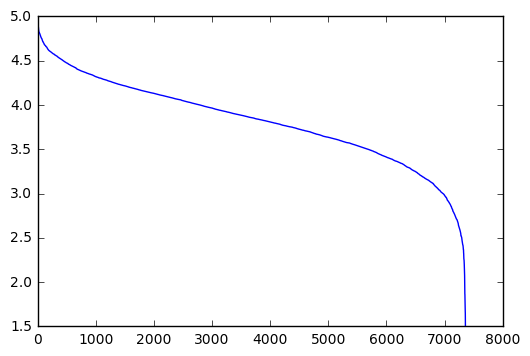

In [95]:
i = 0
plt.plot(predictions[np.argsort(np.ravel(predictions[:,i]))[::-1], i])
plt.show()

# Conclusion of Performance:
* **The overall accuracy of the dataset, including the masked values is about 98.8% (maybe overfitting) or 94.4%**

* **The recommender system model captures the ratings with a good accuracy based on hit or miss evaluation**

* **The performance on the test set was better with 75 features, lambda=10, 100 iterations with an MSE = 1.07**

# Recommend businesses to users

In [96]:
# The recommend function take the Y matrix, and predictions matrix and the user_id
# Returns: the recommended businesses (in desc sorted order), business_id and business index positions
def recommend(Y, predictions, user_id):
    # get index position of user_id
    user_idx = Y.columns.get_loc(user_id)    
    # find index positions of non reviewed businesses for this user:
    all_recommendation_indices = np.squeeze(np.asarray(np.argsort(predictions[:,user_idx], axis=0)[::-1]))
    # find reviewed businesses, find predictions(recommendations) for our user, return businesses in descending sorted order
    # remove reviewed businesses from recommendations
    rated_businesses = [Y.loc[:,user_id].index.get_loc(i) for i in Y.loc[:,user_id][Y.loc[:,user_id].notnull()].index.tolist()]
    all_recommendation_indices = all_recommendation_indices[~np.in1d(all_recommendation_indices,rated_businesses)]
    return Y.index[all_recommendation_indices], all_recommendation_indices


In [97]:
recommended_business_names, recommended_business_idx = recommend(Y, predictions, Y.columns[1])

## Set business_id as index for the business dataframe

In [98]:
# This could have been done from the beginning, keeping the business_id index
business.set_index('business_id', drop=False, verify_integrity=True, inplace=True)

In [99]:
business.loc[recommended_business_names][:3]

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
business_id,,,,,,,,,,,,,,,
lliksv-tglfUz1T3B3vgvA,"{'Noise Level': 'average', 'Ambience': {'casua...",lliksv-tglfUz1T3B3vgvA,"[Thai, Restaurants]",Las Vegas,"953 E Sahara Ave\nSte A5\nEastside\nLas Vegas,...","{'Sunday': {'close': '22:00', 'open': '17:30'}...",36.143767,-115.140885,Lotus of Siam,"[Eastside, Downtown]",True,3225,4.0,NV,business
mQde7KRomOQoUyPGTqeXhA,{},mQde7KRomOQoUyPGTqeXhA,"[Animal Shelters, Veterinarians, Pet Stores, P...",Phoenix,"1521 W Dobbins Rd\nPhoenix, AZ 85041","{'Sunday': {'close': '18:00', 'open': '11:00'}...",33.362442,-112.092663,Arizona Humane Society,[],True,64,4.5,AZ,business
GmzpzmxinfLMw5OXQKFEBQ,"{'Noise Level': 'average', 'Ambience': {'casua...",GmzpzmxinfLMw5OXQKFEBQ,"[Barbeque, Restaurants]",Phoenix,"4301 E University Dr\nPhoenix, AZ 85034","{'Wednesday': {'close': '16:00', 'open': '11:0...",33.421587,-111.989088,Little Miss BBQ,[],True,944,5.0,AZ,business


## Filtering Recommendations to only businesses within states that user had been to (based on user reviewed businesses)

In [100]:
business.loc[recommended_business_names] # regardless of the state

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
business_id,,,,,,,,,,,,,,,
lliksv-tglfUz1T3B3vgvA,"{'Noise Level': 'average', 'Ambience': {'casua...",lliksv-tglfUz1T3B3vgvA,"[Thai, Restaurants]",Las Vegas,"953 E Sahara Ave\nSte A5\nEastside\nLas Vegas,...","{'Sunday': {'close': '22:00', 'open': '17:30'}...",36.143767,-115.140885,Lotus of Siam,"[Eastside, Downtown]",True,3225,4.0,NV,business
mQde7KRomOQoUyPGTqeXhA,{},mQde7KRomOQoUyPGTqeXhA,"[Animal Shelters, Veterinarians, Pet Stores, P...",Phoenix,"1521 W Dobbins Rd\nPhoenix, AZ 85041","{'Sunday': {'close': '18:00', 'open': '11:00'}...",33.362442,-112.092663,Arizona Humane Society,[],True,64,4.5,AZ,business
GmzpzmxinfLMw5OXQKFEBQ,"{'Noise Level': 'average', 'Ambience': {'casua...",GmzpzmxinfLMw5OXQKFEBQ,"[Barbeque, Restaurants]",Phoenix,"4301 E University Dr\nPhoenix, AZ 85034","{'Wednesday': {'close': '16:00', 'open': '11:0...",33.421587,-111.989088,Little Miss BBQ,[],True,944,5.0,AZ,business
CZBYYCb4xBwNlSIYNc6Eiw,"{'Accepts Credit Cards': True, 'Parking': {'st...",CZBYYCb4xBwNlSIYNc6Eiw,"[Active Life, Hiking]",Apache Junction,"6109 N. Apache Trail\nApache Junction, AZ 85219",{},33.461401,-111.485730,"Siphon Draw Trail inc. Flatiron, Superstition ...",[],True,49,5.0,AZ,business
AtjsjFzalWqJ7S9DUFQ4bw,"{'Noise Level': 'very_loud', 'Ambience': {'cas...",AtjsjFzalWqJ7S9DUFQ4bw,"[Hotels & Travel, Arts & Entertainment, Casino...",Las Vegas,"3708 Las Vegas Blvd S\nThe Strip\nLas Vegas, N...","{'Sunday': {'close': '00:00', 'open': '00:00'}...",36.109915,-115.174642,The Cosmopolitan of Las Vegas,[The Strip],True,3228,4.0,NV,business
nYer89hXYAoddMEKTxw7kA,{'Good for Kids': False},nYer89hXYAoddMEKTxw7kA,"[Yelp Events, Local Flavor]",Phoenix,"FilmBar\n815 N 2nd St\nPhoenix, AZ 85004",{},33.457106,-112.071074,Yelp's Secret Cinema: Made In Arizona,[],True,38,5.0,AZ,business
qrjPKkSPzodIfP0kW1mtEw,"{'Price Range': 2, 'Wheelchair Accessible': Tr...",qrjPKkSPzodIfP0kW1mtEw,"[Hair Salons, Skin Care, Hair Removal, Beauty ...",Scottsdale,"4328 N Wells Fargo Ave\nSte 2\nScottsdale, AZ ...","{'Sunday': {'close': '18:00', 'open': '10:00'}...",33.499149,-111.923063,Salon D'Shayn,[],True,230,4.5,AZ,business
qcF6SHcGRML7gihfpNl_zA,"{'Wheelchair Accessible': True, 'Parking': {'s...",qcF6SHcGRML7gihfpNl_zA,"[Skin Care, Threading Services, Laser Hair Rem...",Las Vegas,2960 S Durango Dr\nSte 112\nWestside\nLas Vega...,"{'Sunday': {'close': '18:00', 'open': '11:00'}...",36.135543,-115.277850,Fabulous Eyebrow Threading,[Westside],True,413,5.0,NV,business
84NQRcMC0ldIC86yRw0vpA,"{'Price Range': 1, 'Wheelchair Accessible': Tr...",84NQRcMC0ldIC86yRw0vpA,"[Food, Ice Cream & Frozen Yogurt, Gelato, Dess...",Mesa,"5251 E Brown Rd\nSte 104\nMesa, AZ 85205","{'Sunday': {'close': '20:30', 'open': '14:00'}...",33.437338,-111.717932,Gelato Dolce Vita,[],True,178,5.0,AZ,business


In [101]:
user_id = Y.columns[1]

In [102]:
user_states = business.loc[Y.iloc[:,1][Y.iloc[:,1].notnull()].index].state.unique()
user_states

array(['AZ', 'NV'], dtype=object)

In [103]:
business.loc[recommended_business_names].groupby('state').size()

state
AZ    3206
NC     536
NV    3111
PA     372
QC       4
SC       5
WI       1
dtype: int64

## Business recommeded to a user

In [104]:
# business.loc[recommended_business_names][business.state.isin(user_states)]  # UserWarning: Boolean Series key will be reindexed to match DataFrame index.
business.loc[recommended_business_names][business.loc[recommended_business_names].state.isin(user_states)]

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
business_id,,,,,,,,,,,,,,,
lliksv-tglfUz1T3B3vgvA,"{'Noise Level': 'average', 'Ambience': {'casua...",lliksv-tglfUz1T3B3vgvA,"[Thai, Restaurants]",Las Vegas,"953 E Sahara Ave\nSte A5\nEastside\nLas Vegas,...","{'Sunday': {'close': '22:00', 'open': '17:30'}...",36.143767,-115.140885,Lotus of Siam,"[Eastside, Downtown]",True,3225,4.0,NV,business
mQde7KRomOQoUyPGTqeXhA,{},mQde7KRomOQoUyPGTqeXhA,"[Animal Shelters, Veterinarians, Pet Stores, P...",Phoenix,"1521 W Dobbins Rd\nPhoenix, AZ 85041","{'Sunday': {'close': '18:00', 'open': '11:00'}...",33.362442,-112.092663,Arizona Humane Society,[],True,64,4.5,AZ,business
GmzpzmxinfLMw5OXQKFEBQ,"{'Noise Level': 'average', 'Ambience': {'casua...",GmzpzmxinfLMw5OXQKFEBQ,"[Barbeque, Restaurants]",Phoenix,"4301 E University Dr\nPhoenix, AZ 85034","{'Wednesday': {'close': '16:00', 'open': '11:0...",33.421587,-111.989088,Little Miss BBQ,[],True,944,5.0,AZ,business
CZBYYCb4xBwNlSIYNc6Eiw,"{'Accepts Credit Cards': True, 'Parking': {'st...",CZBYYCb4xBwNlSIYNc6Eiw,"[Active Life, Hiking]",Apache Junction,"6109 N. Apache Trail\nApache Junction, AZ 85219",{},33.461401,-111.485730,"Siphon Draw Trail inc. Flatiron, Superstition ...",[],True,49,5.0,AZ,business
AtjsjFzalWqJ7S9DUFQ4bw,"{'Noise Level': 'very_loud', 'Ambience': {'cas...",AtjsjFzalWqJ7S9DUFQ4bw,"[Hotels & Travel, Arts & Entertainment, Casino...",Las Vegas,"3708 Las Vegas Blvd S\nThe Strip\nLas Vegas, N...","{'Sunday': {'close': '00:00', 'open': '00:00'}...",36.109915,-115.174642,The Cosmopolitan of Las Vegas,[The Strip],True,3228,4.0,NV,business
nYer89hXYAoddMEKTxw7kA,{'Good for Kids': False},nYer89hXYAoddMEKTxw7kA,"[Yelp Events, Local Flavor]",Phoenix,"FilmBar\n815 N 2nd St\nPhoenix, AZ 85004",{},33.457106,-112.071074,Yelp's Secret Cinema: Made In Arizona,[],True,38,5.0,AZ,business
qrjPKkSPzodIfP0kW1mtEw,"{'Price Range': 2, 'Wheelchair Accessible': Tr...",qrjPKkSPzodIfP0kW1mtEw,"[Hair Salons, Skin Care, Hair Removal, Beauty ...",Scottsdale,"4328 N Wells Fargo Ave\nSte 2\nScottsdale, AZ ...","{'Sunday': {'close': '18:00', 'open': '10:00'}...",33.499149,-111.923063,Salon D'Shayn,[],True,230,4.5,AZ,business
qcF6SHcGRML7gihfpNl_zA,"{'Wheelchair Accessible': True, 'Parking': {'s...",qcF6SHcGRML7gihfpNl_zA,"[Skin Care, Threading Services, Laser Hair Rem...",Las Vegas,2960 S Durango Dr\nSte 112\nWestside\nLas Vega...,"{'Sunday': {'close': '18:00', 'open': '11:00'}...",36.135543,-115.277850,Fabulous Eyebrow Threading,[Westside],True,413,5.0,NV,business
84NQRcMC0ldIC86yRw0vpA,"{'Price Range': 1, 'Wheelchair Accessible': Tr...",84NQRcMC0ldIC86yRw0vpA,"[Food, Ice Cream & Frozen Yogurt, Gelato, Dess...",Mesa,"5251 E Brown Rd\nSte 104\nMesa, AZ 85205","{'Sunday': {'close': '20:30', 'open': '14:00'}...",33.437338,-111.717932,Gelato Dolce Vita,[],True,178,5.0,AZ,business


In [105]:
# Get ordinal index position of businesses rated by user_id
# [Y.loc[:,user_id].index.get_loc(i) for i in Y.loc[:,user_id][Y.loc[:,user_id].notnull()].index.tolist()]

In [106]:
# We cant use rev_biz_usr because it contained some entries that were removed in the Y matrix
# business.loc[rev_biz_usr[rev_biz_usr.user_id == user_id].business_id.unique()]

In [110]:
business.loc[recommended_business_names][business.loc[recommended_business_names].state.isin(user_states)].stars.values

array([ 4. ,  4.5,  5. , ...,  2. ,  1.5,  1.5])

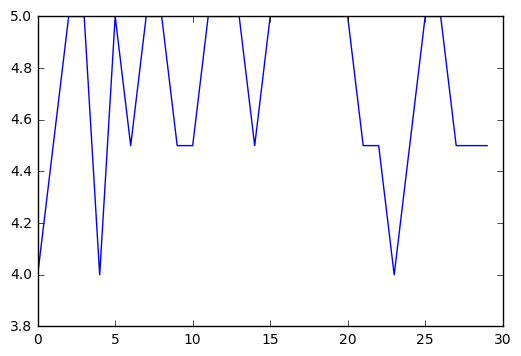

In [114]:
# Ratings of the top 30 recommended businesses
plt.plot(business.loc[recommended_business_names][business.loc[recommended_business_names].state.isin(user_states)].stars.values[:30])
plt.show()